<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection_phase8b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Read dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
# from category_encoders import CountEncoder
import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000
# pd.options.display.max_colwidth = 1000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Export Data

In [ ]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [ ]:
# df = reduce_mem_usage_sd(df, verbose=True)
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase7.csv')
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase7.csv', index_col=[0])
df = reduce_mem_usage_sd(df, verbose=True)
gc.collect()

Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=20902
Column card1: int64 -> int16, na_count=0, n_uniq=13553
Column card2: int64 -> int16, na_count=0, n_uniq=501
Column card3: int64 -> int8, na_count=0, n_uniq=115
Column card5: int64 -> int8, na_count=0, n_uniq=120
Column addr1: float64 -> int16, na_count=0, n_uniq=332
Column dist1: float64 -> int16, na_count=0, n_uniq=2651
Column C1: int64 -> int16, na_count=0, n_uniq=1657
Column C5: int64 -> int16, na_count=0, n_uniq=319
Column C13: int64 -> int16, na_count=0, n_uniq=1597
Column D1: float64 -> int16, na_count=0, n_uniq=641
Column D3: float64 -> int16, na_count=0, n_uniq=649
Column D4: float64 -> int16, na_count=0, n_uniq=808
Column D5: float64 -> int16, na_count=0, n_uniq=688
Column D8: float64 -> float32, na_count=0, n_uniq=12353
Column D9: float64 -> float16, na_count=0, n_uniq=24
Column D10: float64 -> int16, na_count=0, n_uniq=818
Column D11: float64 -> int16, na_c

15

In [ ]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C1,C5,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,V2,V3,V4,V6,V7,V8,V9,V10,V12,V15,V17,V19,V23,V24,V25,V26,V29,V35,...,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,TransactionAmt_winsorize,TransactionAmt_log,TransactionAmt_sqrt,TransactionAmt_z,ProductCD_freq,DeviceInfo_freq,DeviceType_freq,Transaction_day_of_week_freq,Transaction_hour_freq,R_emaildomain_1_freq,R_emaildomain_2_freq,R_emaildomain_3_freq,P_emaildomain_1_freq,P_emaildomain_2_freq,P_emaildomain_3_freq,id_12_freq,id_28_freq,id_30_freq,id_31_freq,id_34_freq,id_35_freq,id_36_freq,id_37_freq,id_38_freq,M2_freq,M3_freq,M4_freq,M5_freq,M6_freq,M7_freq,M8_freq,M9_freq,card4_freq,card6_freq
0,0,68.5,13926,0,43,39,315,19,1,0,1,14,13,26,10,37.875,0.666504,13,13,0,0,0,2,2,2,2,2,2,2,1,2,1,1,2,2,2,2,2,1,0,...,0.0000,0.000000,0.000000,0.0000,0.000000,500,8.276473,5.226834,8.276473,-0.278167,0.744629,0.798828,0.761719,0.166748,0.064001,0.767578,0.767578,0.995605,0.159912,0.160767,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.483398,0.426270,0.101379,0.224365,0.327393,0.586426,0.586426,0.586426,0.011261,0.252197
1,0,29.0,2755,304,43,3,325,8,1,0,1,0,8,0,10,37.875,0.666504,0,43,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,1,1,...,0.0000,0.000000,0.000000,0.0000,0.000000,0,5.385165,4.367296,5.385165,-0.443327,0.744629,0.798828,0.761719,0.166748,0.064001,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.458984,0.458984,0.332520,0.182129,0.327393,0.586426,0.586426,0.586426,0.320312,0.252197
2,0,59.0,4663,390,43,59,330,287,1,0,1,0,8,0,10,37.875,0.666504,0,315,0,0,315,2,2,2,2,2,2,2,1,2,1,1,2,2,2,2,2,1,2,...,1.8650,1.851016,1.541448,1.6110,1.486472,0,7.681146,5.077538,7.681146,-0.317889,0.744629,0.798828,0.761719,0.166748,0.064001,0.767578,0.767578,0.995605,0.009369,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.483398,0.426270,0.332520,0.224365,0.385742,0.357910,0.262939,0.065430,0.651367,0.745117
3,0,50.0,18132,467,43,15,476,8,2,0,25,112,0,94,0,37.875,0.666504,84,43,0,0,111,0,0,0,0,0,0,0,0,2,1,1,2,2,2,2,2,1,2,...,0.7200,0.520531,0.558392,0.6860,0.576638,0,7.071068,4.912023,7.071068,-0.355521,0.744629,0.798828,0.761719,0.166748,0.064001,0.767578,0.767578,0.995605,0.174316,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.458984,0.458984,0.332520,0.182129,0.385742,0.586426,0.586426,0.586426,0.320312,0.745117
4,0,50.0,4497,414,43,3,420,8,1,0,1,0,8,26,10,37.875,0.666504,15,43,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.3198,0.323874,0.256558,0.4595,0.408718,0,7.071068,4.912023,7.071068,-0.355521,0.055908,0.020248,0.094238,0.166748,0.064001,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.208374,0.109619,0.010674,0.003805,0.101624,0.131714,0.227051,0.187012,0.113586,0.458984,0.458984,0.476562,0.593262,0.286865,0.586426,0.586426,0.586426,0.320312,0.252197


### Modeling with LightGBM

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
# LGBMClassifier with GPU

# clf = LGBMClassifier(
#           max_bin = 63,
#           num_leaves = 255,
#           num_iterations = 500,
#           learning_rate = 0.01,
#           tree_learner = 'serial',
#           task = 'df',
#           is_dfing_metric = False,
#           min_data_in_leaf = 1,
#           min_sum_hessian_in_leaf = 100,
#           sparse_threshold=1.0,
#           # device = 'gpu',
#           num_thread = -1,
#           save_binary= True,
#           seed= 42,
#           feature_fraction_seed = 42,
#           bagging_seed = 42,
#           drop_seed = 42,
#           data_random_seed = 42,
#           objective = 'binary',
#           boosting_type = 'gbdt',
#           verbose = 1,
#           metric = 'auc',
#           is_unbalance = True,
#           boost_from_average = False,
# )

clf = LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)



In [ ]:
%time clf.fit(X_train, y_train)
# %time prints CPU Times and Wall Time

CPU times: user 3min 5s, sys: 541 ms, total: 3min 5s
Wall time: 1min 35s


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [ ]:
gc.collect()

99

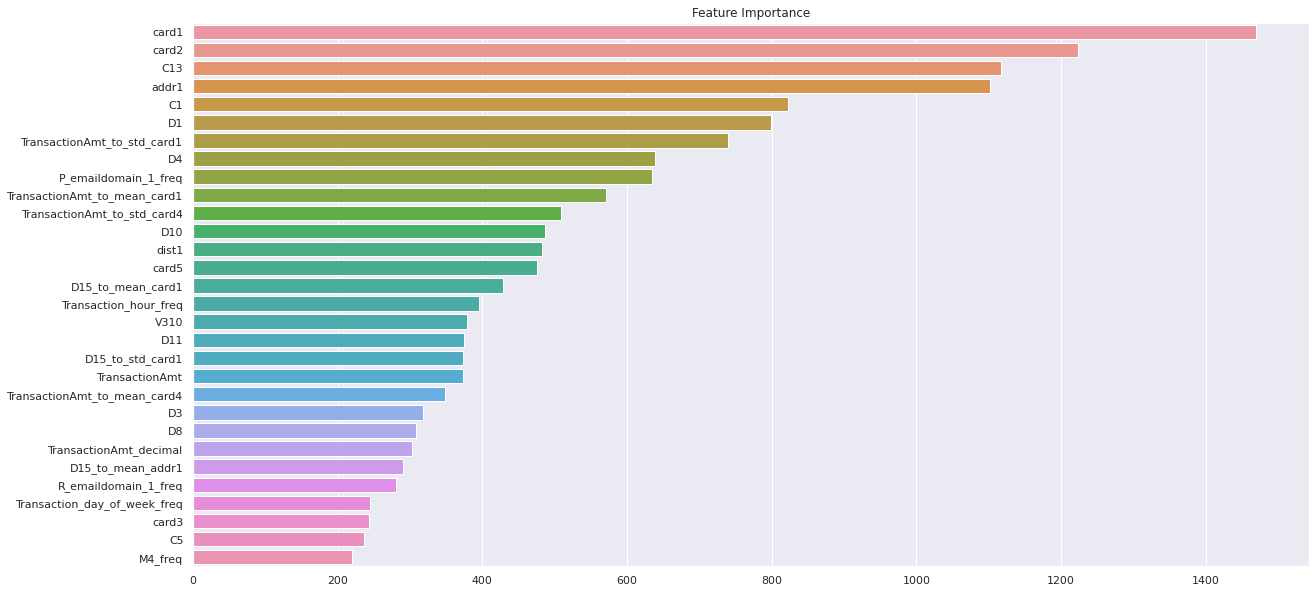

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

plot_feature_importances(clf, 30)

In [ ]:
y_pred = clf.predict(X_test)

### Evaluation of LightGBM

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    142469
           1       0.29      0.79      0.42      5166

    accuracy                           0.92    147635
   macro avg       0.64      0.86      0.69    147635
weighted avg       0.97      0.92      0.94    147635



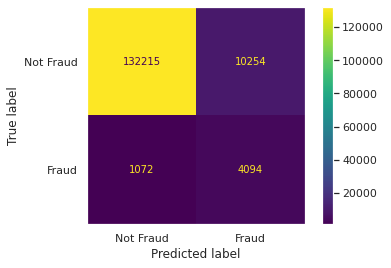

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

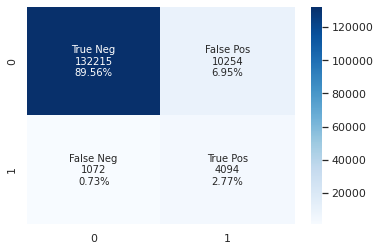

In [ ]:
# Alternative
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    427408
           1       0.32      0.89      0.47     15497

    accuracy                           0.93    442905
   macro avg       0.66      0.91      0.71    442905
weighted avg       0.97      0.93      0.94    442905



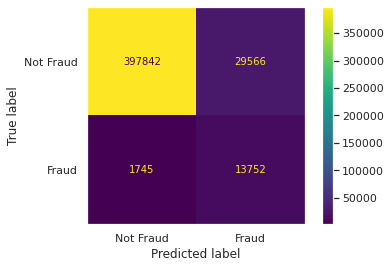

In [ ]:
y_train_pred = clf.predict(X_train)
plot_confusion_matrix(clf, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

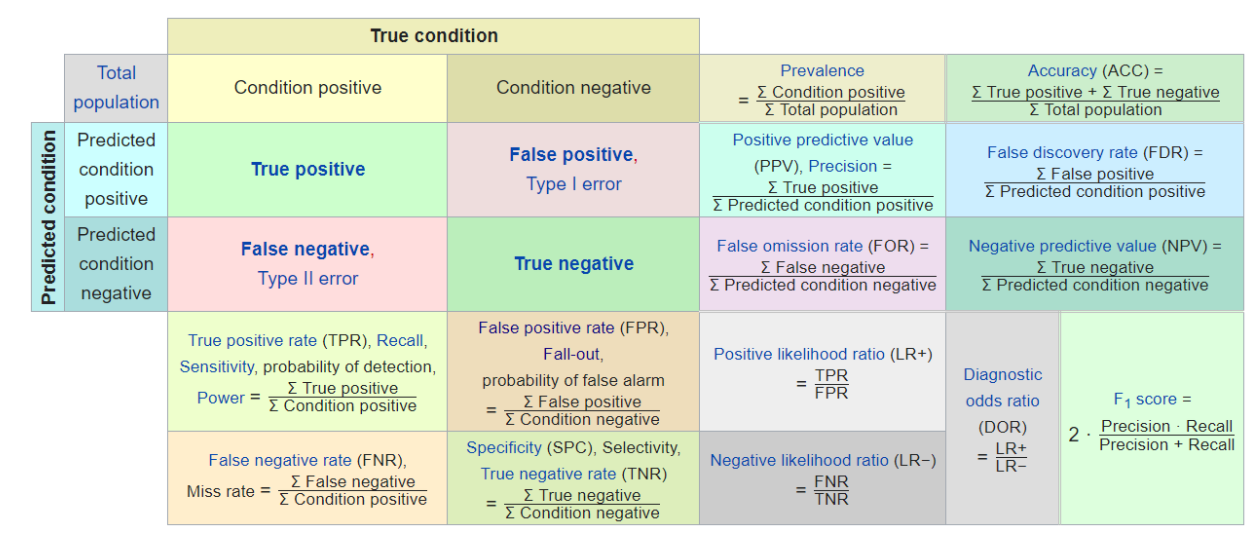

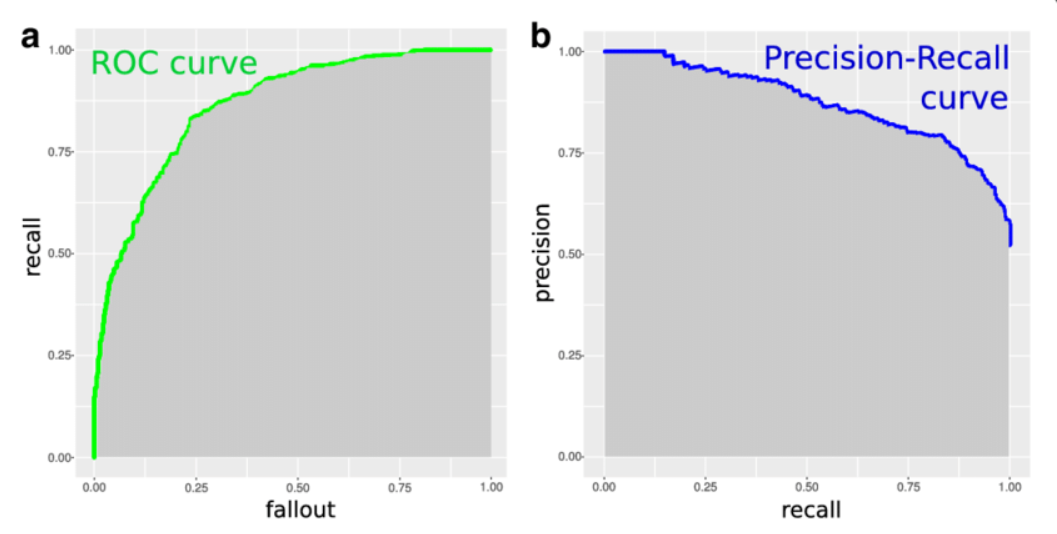

<Figure size 720x720 with 0 Axes>

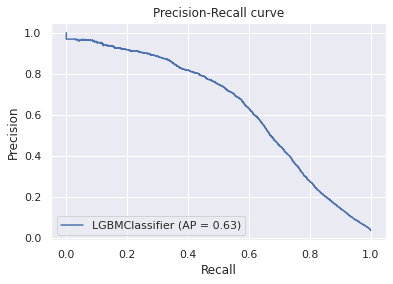

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve');

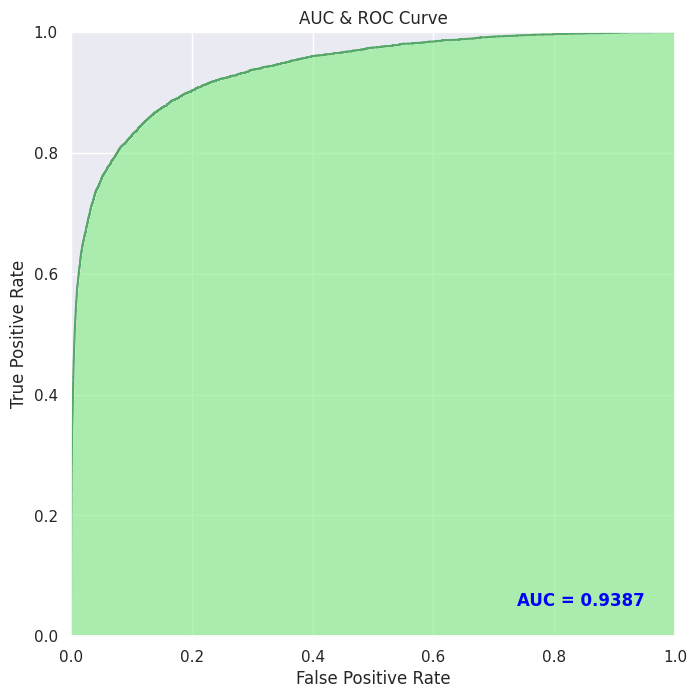

In [ ]:
from sklearn import metrics

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [ ]:
# scores = cross_val_score(clf, X_test, y_test, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

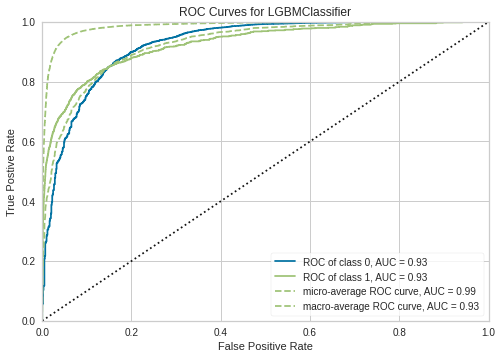

In [ ]:
from yellowbrick.classifier import ROCAUC, roc_auc

roc_auc(clf, X_test, y_test) 

### Modeling with XGBoost

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
# from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
xgb = XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )

In [ ]:
%time xgb.fit(X_train, y_train)

CPU times: user 56min 28s, sys: 4.69 s, total: 56min 33s
Wall time: 56min 12s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [ ]:
gc.collect()

96

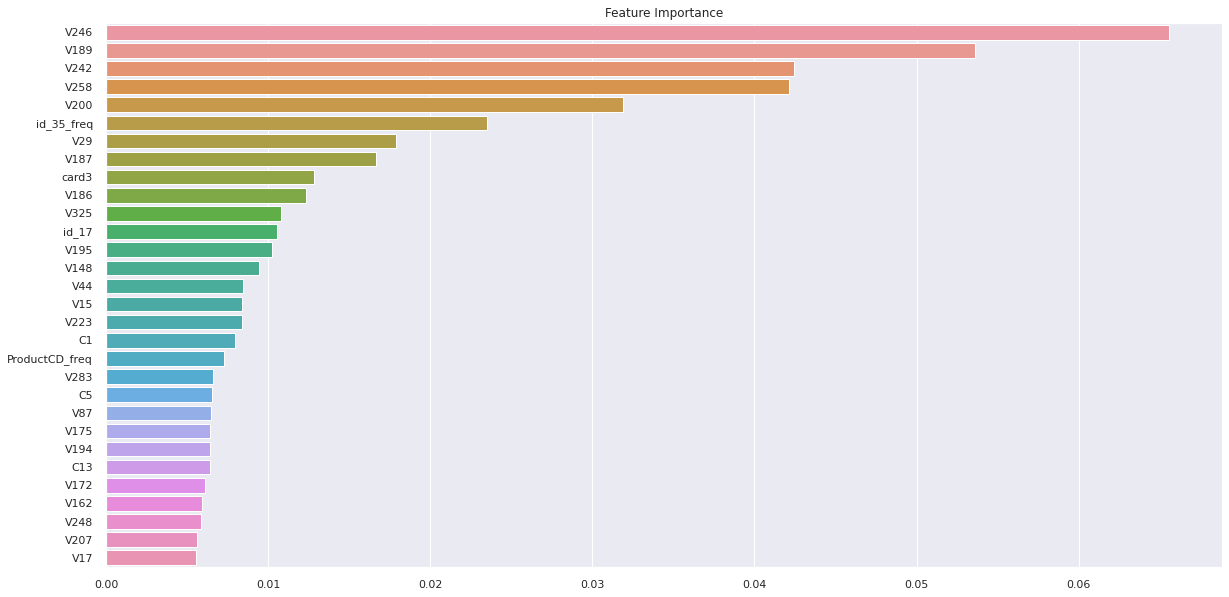

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()
    
plot_feature_importances(xgb, 30)

In [ ]:
y_pred = xgb.predict(X_test)

### Evaluation of XgGBoost

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    142469
           1       0.96      0.61      0.75      5166

    accuracy                           0.99    147635
   macro avg       0.97      0.80      0.87    147635
weighted avg       0.99      0.99      0.98    147635



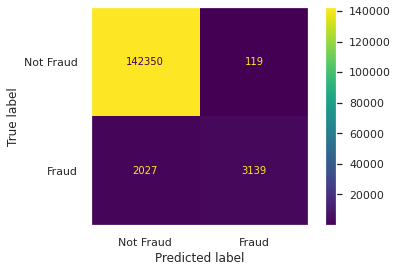

In [ ]:
plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

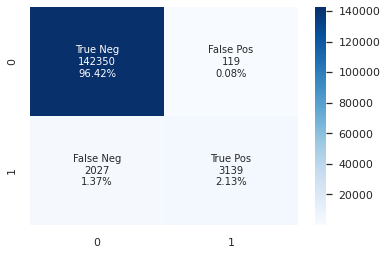

In [ ]:
# Alternative
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    427408
           1       1.00      0.95      0.97     15497

    accuracy                           1.00    442905
   macro avg       1.00      0.97      0.99    442905
weighted avg       1.00      1.00      1.00    442905



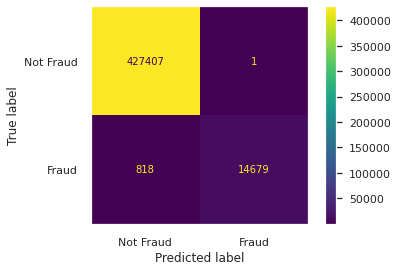

In [ ]:
y_train_pred = xgb.predict(X_train)
plot_confusion_matrix(xgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

<Figure size 720x720 with 0 Axes>

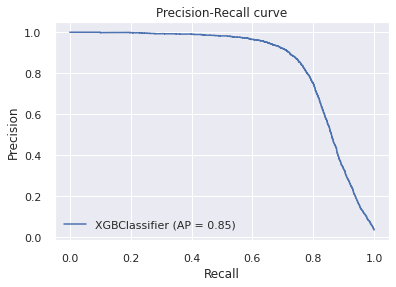

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(xgb, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve');

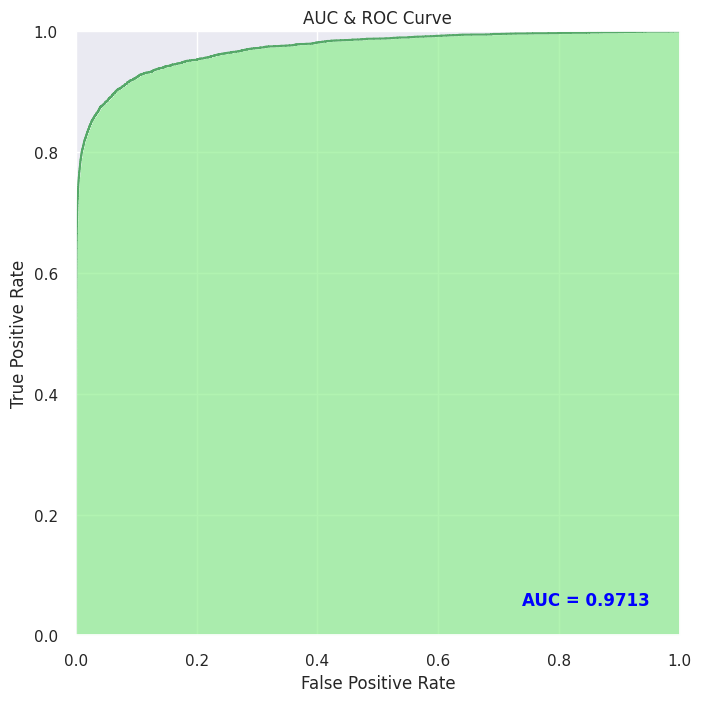

In [ ]:
from sklearn import metrics

# xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [ ]:
# scores = cross_val_score(clf, X_test, y_test, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

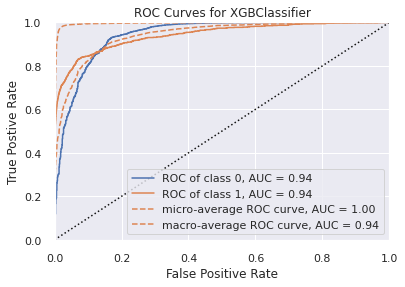

In [ ]:
from yellowbrick.classifier import ROCAUC, roc_auc

roc_auc(xgb, X_test, y_test) 